### Yogo Posses Classification - TensorFlow Model + Transfare Leaning `VGG19`
In this **notebook** we are going to create a **NN** that classify different Yoga Poses.

* Dataset [download](https://www.kaggle.com/niharika41298/yoga-poses-dataset).

### Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import numpy as np
import os, shutil
import matplotlib.pyplot as plt

### Data Preparation

File Structures

```py
DATASET
    TRAIN
        - downdog
            -
        - goddess
            -
        - plank
            -
        - tree
            -
        - warrior2
            -
    TEST
        - downdog
            -
        - goddess
            -
        - plank
            -
        - tree
            -
        - warrior2
            -
            
Key:
- = images
```

In [2]:
class Paths:
    ROOT = "DATASET"
    TRAIN = "DATASET/TRAIN"
    TEST = "DATASET/TEST"

### Creating Image Data Generator for both `train` and `test` datasets.

In [69]:
datagen = image.ImageDataGenerator(
    rescale=1.0 / 255,
    data_format="channels_last",
    dtype=tf.float32,
)

### Creating `test` and `train` datasets.

In [106]:
train_ds = datagen.flow_from_directory(
    Paths.TRAIN,
    target_size=(96, 96),
    batch_size=32,
    #color_mode="grayscale",
    class_mode="categorical",
    shuffle=True,
    seed=42,
)

test_ds = datagen.flow_from_directory(
    Paths.TEST,
    target_size=(96, 96),
    batch_size=32,
#   color_mode="grayscale",
    class_mode="categorical",
    shuffle=True,
    seed=42,
)

Found 1039 images belonging to 5 classes.
Found 470 images belonging to 5 classes.


In [31]:
train_ds.class_indices

{'downdog': 0, 'goddess': 1, 'plank': 2, 'tree': 3, 'warrior2': 4}

In [107]:
batch= iter(train_ds).__next__()

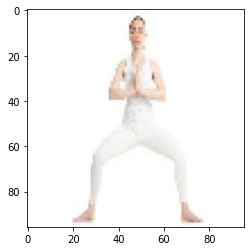

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [108]:
plt.imshow(batch[0][20], cmap="gray")
plt.show()
batch[1][:20]

### `NN` achitecture.

```
        [ ConvBlock ] -> Conv2D -> BatchNormalization -> ReLU 
             |
             |
        [Flatten Layer / GlobalMaxPooling2D]
             |
        [Output Block] -> Dense Layers

```

In [109]:
class ConvBlock(keras.layers.Layer):
    def __init__(self, in_features, kernel_size=(3, 3)):
        super(ConvBlock, self).__init__()
        self.conv = keras.layers.Conv2D(in_features, kernel_size, padding="same", input_shape=(96, 96, 3))
        self.bn = keras.layers.BatchNormalization()
        self.relu = keras.activations.relu
        
    def call(self, x, training=False):
        x = self.conv(x)
        x = self.bn(x, training=training)
        return self.relu(x)

### A ``Sequential`` Model.

In [110]:
seq_model = keras.Sequential([
    ConvBlock(64),
    ConvBlock(128),
    ConvBlock(64),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(5, activation='softmax'),
], name="seq_model")

seq_model.build((None, 96, 96, 3))
seq_model.summary()

Model: "seq_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_block (ConvBlock)       (None, 96, 96, 64)        2048      
_________________________________________________________________
conv_block_1 (ConvBlock)     (None, 96, 96, 128)       74368     
_________________________________________________________________
conv_block_2 (ConvBlock)     (None, 96, 96, 64)        74048     
_________________________________________________________________
flatten_1 (Flatten)          (None, 589824)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                37748800  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                82

### ``Sub-classing`` Model.

In [111]:
class YogaNet(keras.Model):
    def __init__(self, in_features=np.array([64, 128, 64]), n_classes=5):
        super(YogaNet, self).__init__()
        self.conv_block_1 = ConvBlock(in_features[0])
        self.conv_block_2 = ConvBlock(in_features[1])
        self.conv_block_3 = ConvBlock(in_features[2])
        self.flatten = keras.layers.Flatten()
        self.dense_1 = keras.layers.Dense(in_features[0], activation='relu')
        self.dense_2 = keras.layers.Dense(in_features[1], activation='relu')
        self.dense_3 = keras.layers.Dense(in_features[2], activation='relu')
        self.dense_4 = keras.layers.Dense(n_classes, activation='softmax')
        
    def call(self, x, training=False):
        x = self.conv_block_1(x, training=training)
        x = self.conv_block_2(x, training=training)
        x = self.conv_block_3(x, training=training)
        
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.dense_4(x)
    
    def model(self):
        input_shape = keras.layers.Input((96, 96, 3))
        return keras.Model(inputs=[input_shape], outputs=self.call(input_shape))
        

In [47]:
yoga_net = YogaNet()
yoga_net.model().summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv_block_18 (ConvBlock)    (None, 96, 96, 64)        2048      
_________________________________________________________________
conv_block_19 (ConvBlock)    (None, 96, 96, 128)       74368     
_________________________________________________________________
conv_block_20 (ConvBlock)    (None, 96, 96, 64)        74048     
_________________________________________________________________
flatten_6 (Flatten)          (None, 589824)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                37748800  
_________________________________________________________________
dense_25 (Dense)             (None, 128)               832

### Custom `.fit()`, `.compile()` and `.evaluate()`

* Demostrating how we can create our custom `.fit()`, `.compile()` and `.evaluate()`

In [112]:
class Model(keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    # .compile()
    def compile(self, loss, optimizer, metrics):
        super().compile()
        self.loss = loss
        self.optimizer = optimizer
        self.custom_metrics = metrics
        
    # .fit()
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            pred = self.model(x, training=True)
            loss = self.loss(y, pred)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.custom_metrics.update_state(y, pred)
        
        return {"loss": loss, "accuracy": self.custom_metrics.result()}
        
    # .evaluate()
    def test_step(self, data):
        x, y = data
        pred = self.model(x, training=False)
        loss = self.loss(y, pred)
        self.custom_metrics.update_state(y, pred)
        return {"loss": loss, "accuracy": self.custom_metrics.result()}

> The custom `.fit()`, `.evaluate()` and `.compile()` does not work on the `SubClassing` API.

### Trainning the `yoga_model`

In [113]:
yoga_net.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(lr=0.001),
    metrics = keras.metrics.CategoricalAccuracy(name="acc")
)

BATCH_SIZE = 32

lr_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor='val_acc', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0, mode='auto'
)

history = yoga_net.fit(
    train_ds, 
    shuffle=True,
    validation_data = test_ds,
    verbose = 1,
    batch_size = BATCH_SIZE,
    callbacks = [lr_reduction, early_stopping]
)

33/33 [==============================] - 415s 12s/step - loss: 10.0642 - acc: 0.2515 - val_loss: 1.7458 - val_acc: 0.1468


> We are not able to achive good accuracy on this model, because of a lot of reasons. So we are going to try suing **Transfare Learning** to improve the model accuracy.

### Transfare Learning - `VGG19`

In [91]:
from tensorflow.keras.applications.vgg16 import VGG16,  preprocess_input
from tensorflow.keras.applications import VGG19

In [92]:
IMG_H = 200
IMG_W = 200
IMG_C = 3

BATCH_SIZE = 32
EPOCHS = 2

In [103]:
train_set = datagen.flow_from_directory(
    Paths.TRAIN,
    target_size=(IMG_W, IMG_H),
    batch_size=BATCH_SIZE,
    #color_mode="grayscale",
    class_mode="categorical",
    shuffle=True,
    seed=42,
)

test_set = datagen.flow_from_directory(
    Paths.TEST,
    target_size=(IMG_W, IMG_H),
    batch_size=BATCH_SIZE,
#   color_mode="grayscale",
    class_mode="categorical",
    shuffle=True,
    seed=42,
)

Found 1039 images belonging to 5 classes.
Found 470 images belonging to 5 classes.


In [104]:
def create_model():
    keras.backend.clear_session()
    base_model = VGG19(input_shape = (IMG_W, IMG_H, IMG_C), 
                         weights='imagenet', 
                         include_top=False,)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    x = keras.layers.Flatten()(base_model.output)
    outputs = keras.layers.Dense(5, activation="softmax")(x)
    
    model = keras.Model(inputs=base_model.input, outputs=outputs, name="vgg19_tl")
    return model

In [97]:
model = create_model()
model.summary()

Model: "vgg19_tl"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0  

In [105]:
model.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(lr=0.001),
    metrics = ["acc"]
)

lr_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor='val_acc', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0, mode='auto'
)

history = model.fit(
    train_set, 
    shuffle=True,
    validation_data = test_set,
    verbose = 1,
    batch_size = BATCH_SIZE,
    callbacks = [lr_reduction, early_stopping]
)

33/33 [==============================] - 593s 18s/step - loss: 0.4948 - acc: 0.8310 - val_loss: 0.0715 - val_acc: 0.9830


> **OPS!!** I really need a `GPU` 


I'm not going to train this model for a long period of time because of some `CPU` limitations, but as we can see that our model is pretty doing better on the `test` and `train` accuracy.

Credits:

* [rahulbana](https://www.kaggle.com/rahulbana/yoga-poses-dataset-eda-with-modeling)